In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/plant-seedlings/"

In [4]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs(n)

In [5]:
label_df = pd.read_csv(label_csv)

## Removing space between class names

In [ ]:
label_df.species = label_df.species.apply(lambda x: re.sub(' ', '_', x))
label_df.to_csv(f'{PATH}labels.csv', index=False)

## Pivot table

In [ ]:
label_df.pivot_table(index='species', aggfunc=len).sort_values('file', ascending=False)

## Analysis

In [16]:
def get_sizes(s):
    sz = [PIL.Image.open(f'{PATH}{s}/'+k).size for k in os.listdir(f'{PATH}{s}/')]
    height = np.array([sz[i][0] for i in range(len(sz))])
    width = np.array([sz[i][1] for i in range(len(sz))])
    return height, width

In [17]:
trn_h, trn_w = get_sizes('train'); test_h, test_w = get_sizes('test')

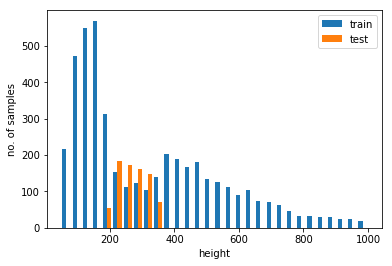

In [29]:
plt.hist([trn_h[trn_h<1000], test_h[test_h<1000]], bins=30); 
plt.xlabel('height'); plt.ylabel('no. of samples'); plt.legend(['train', 'test']);

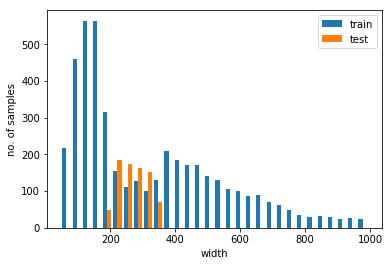

In [30]:
plt.hist([trn_w[trn_w<1000], test_w[test_w<1000]], bins=30); 
plt.xlabel('width'); plt.ylabel('no. of samples'); plt.legend(['train', 'test']);

## Training setup

In [31]:
sz = 128
arch = resnet50
bs = 24

In [32]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                        val_idxs=val_idxs, tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340, 'tmp')

In [33]:
data = get_data(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [34]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 34/34 [00:53<00:00,  1.57s/it]


In [35]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 81%|████████  | 129/159 [00:04<00:01, 26.90it/s, loss=9.27]


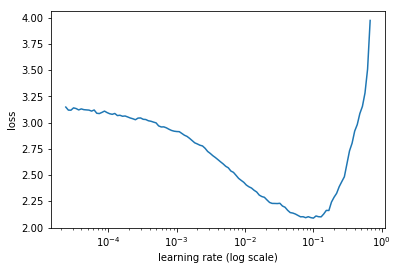

In [36]:
learn.sched.plot()

In [37]:
lr = 1e-2

In [38]:
learn.fit(lr, 3, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

[ 0.       1.28582  0.89068  0.69866]                       
[ 1.       0.88638  0.76372  0.73899]                        
[ 2.       0.87826  0.75269  0.73482]                        
[ 3.       0.71732  0.68176  0.76577]                        
[ 4.       0.78498  0.68905  0.76027]                        
[ 5.       0.5775   0.62297  0.77931]                        



In [39]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [40]:
learn.fit(lr, 2, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[ 0.       1.38631  0.92013  0.68542]                       
[ 1.       1.05668  0.81073  0.74182]                       
[ 2.       1.02814  0.75889  0.74018]                       
[ 3.       0.82737  0.69496  0.75714]                        



In [41]:
learn.precompute=False
learn.bn_freeze=True

In [42]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       1.02242  0.68971  0.75357]                        
[ 1.       1.08378  0.69216  0.75848]                       
[ 2.       0.91776  0.66396  0.7689 ]                        



In [43]:
learn.fit(lr, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       0.92651  0.64311  0.77485]                        
[ 1.       0.86651  0.6399   0.77307]                        



In [44]:
learn.unfreeze()

In [45]:
lrs = np.array([lr/20,lr/10,lr])

In [46]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.65118  0.45901  0.83601]                        
[ 1.       0.4467   0.26505  0.9128 ]                        
[ 2.       0.32051  0.26877  0.91667]                        



In [47]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.31065  0.21119  0.91667]                        
[ 1.       0.30446  0.21962  0.92113]                        
[ 2.       0.22261  0.21828  0.92396]                        



In [48]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.23603  0.2268   0.92917]                        
[ 1.       0.20991  0.21587  0.93333]                        
[ 2.       0.17744  0.17555  0.94167]                        



In [49]:
learn.save(f'{sz}')

In [50]:
sz = 256

In [51]:
learn.set_data(get_data(sz, bs))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [52]:
learn.freeze()
learn.fit(lr, 2, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[ 0.       0.25362  0.26461  0.92396]                        
[ 1.       0.2307   0.26703  0.91801]                        
[ 2.       0.22134  0.28867  0.9058 ]                        
[ 3.       0.22063  0.2597   0.91801]                        



In [53]:
learn.precompute

False

In [54]:
learn.fit(lr, 2, cycle_len=1, wds=0.025, use_wd_sched=True, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.21687  0.2524   0.92455]                        
[ 1.       0.23046  0.24972  0.92946]                        
[ 2.       0.21731  0.26291  0.92321]                        



In [55]:
learn.unfreeze()

In [56]:
learn.fit(lrs, 3, cycle_len=1, wds=0.025, use_wd_sched=True, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.22564  0.19998  0.94301]                        
[ 1.       0.21754  0.14144  0.96488]                        
[ 2.       0.17356  0.15707  0.96146]                        
[ 3.       0.19206  0.15917  0.96042]                        
[ 4.       0.14524  0.132    0.96146]                        
[ 5.       0.12674  0.11062  0.97292]                        
[ 6.       0.10767  0.1067   0.97188]                        



In [57]:
wd=0.025

In [58]:
learn.fit(lrs, 2, cycle_len=1, wds=[wd/18, wd/9, wd/2], use_wd_sched=True, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.14813  0.12546  0.96562]                        
[ 1.       0.13933  0.12798  0.96354]                        
[ 2.       0.10735  0.1039   0.97396]                        



In [59]:
learn.save(f'{sz}')

In [60]:
sz = 299

In [61]:
from sklearn import metrics

In [62]:
learn.set_data(get_data(sz, bs))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [63]:
learn.freeze()
learn.fit(lr, 2, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[ 0.       0.05807  0.10553  0.96979]                         
[ 1.       0.04845  0.09806  0.97083]                         
[ 2.       0.04458  0.10339  0.97188]                         
[ 3.       0.04319  0.10306  0.97083]                         



In [64]:
learn.fit(lr, 2, cycle_len=1, wds=wd, use_wd_sched=True, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.06682  0.11793  0.96771]                         
[ 1.       0.09047  0.13042  0.97188]                         
[ 2.       0.09618  0.1349   0.97083]                         



In [65]:
learn.unfreeze()

In [66]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.11048  0.12129  0.96562]                        
[ 1.       0.12989  0.11671  0.95937]                        
[ 2.       0.0821   0.09388  0.96875]                         



In [67]:
learn.save(f'{sz}')

In [68]:
learn.fit(lrs, 2, cycle_len=1, wds=[wd/18, wd/9, wd/2], use_wd_sched=True, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.07665  0.09807  0.97292]                         
[ 1.       0.10644  0.09551  0.975  ]                         
[ 2.       0.07355  0.081    0.98125]                         



In [69]:
learn.save(f'{sz}'+'_wds')

In [72]:
learn.fit(lrs, 2, cycle_len=1, wds=[wd/16, wd/4, wd], use_wd_sched=True, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.0932   0.10898  0.98021]                         
[ 1.       0.10933  0.16003  0.9625 ]                        
[ 2.       0.09997  0.1172   0.97917]                         



In [73]:
learn.save(f'{sz}'+'_wds_2')

In [74]:
sz = 450

In [75]:
learn.set_data(get_data(sz, bs))

In [76]:
learn.freeze()
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.07292  0.13824  0.96562]                         
[ 1.       0.05585  0.13652  0.96146]                         
[ 2.       0.05144  0.12839  0.95833]                         



In [77]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.10886  0.10273  0.96875]                        
[ 1.       0.10805  0.13397  0.95417]                        
[ 2.       0.05803  0.08451  0.97292]                         



In [78]:
learn.save(f'{sz}')

In [79]:
learn.fit(lrs, 2, cycle_len=1, wds=[wd/18, wd/9, wd/2], use_wd_sched=True, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.07537  0.10577  0.96875]                         
[ 1.       0.11065  0.13234  0.95833]                         
[ 2.       0.05908  0.13866  0.96042]                         



In [80]:
learn.save(f'{sz}'+'_wds')

In [ ]:
sz = 500

In [ ]:
learn.set_data(get_data(sz, 16))

In [ ]:
learn.freeze()
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save(f'{sz}')

In [ ]:
learn.fit(lrs, 2, cycle_len=1, wds=[wd/18, wd/9, wd/2], use_wd_sched=True, cycle_mult=2)

In [ ]:
learn.save(f'{sz}'+'_wds')

## Old steps

In [ ]:
learn.set_data(get_data(299, bs))
learn.freeze()

In [ ]:
learn.fit(1e-2, 3, cycle_len=1)

In [ ]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('299_r50')

In [ ]:
learn.load('299_r50')

In [ ]:
learn.set_data(get_data(350, bs))
learn.freeze()

In [ ]:
learn.fit(1e-2, 3, cycle_len=1)

In [ ]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('350_r50')

In [ ]:
learn.load('350_r50')

In [ ]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)

In [ ]:
accuracy(log_preds, y)

In [ ]:
metrics.f1_score()

In [ ]:
learn.save('350_r50')

## Prediction

In [ ]:
log_preds, y = learn.TTA(is_test=True)

In [ ]:
log_preds.shape

In [ ]:
probs = np.mean(np.exp(log_preds), axis=0); probs

In [ ]:
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()

In [ ]:
save_array('probs_500.bc', probs)

## Save to file for submission

In [ ]:
def load_array(fname): return bcolz.open(fname)[:]

In [ ]:
probs_400 = load_array('probs_400.bc')
probs_450 = load_array('probs_450.bc')
probs_500 = load_array('probs_500.bc')

In [ ]:
probs = (probs_450 + probs_450 + probs_500)/3

In [ ]:
data.classes

In [ ]:
df = pd.DataFrame(np.argmax(probs, axis=1))

In [ ]:
df.insert(0, 'file', [o[5:-4] for o in data.test_ds.fnames])

In [ ]:
df.columns = ['file', 'species']

In [ ]:
df.species = df.species.apply(lambda x: data.classes[x])

In [ ]:
df.species = df.species.apply(lambda x: re.sub('_', ' ', x))

In [ ]:
df.file = df.file.apply(lambda x: str(x) + '.png')

In [ ]:
SUBM = f'{PATH}results/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}submission-5.csv', index=False)
#df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)